In [ ]:
from pystan import StanModel
n_jobs = 4
import pandas as pd
import seaborn as sns
sns.set_color_codes()
import pickle
%pylab inline
models = pickle.load(open('model.pkl', 'rb'))

In [ ]:
def test_model_inference(model_name, Y=None, predictors=None, generated_data='data_latent', models=models, 
                         generator_iter=50, inference_iter=1000):
    
    if Y is None:
        Y = pd.DataFrame(rand(100,5))
    if predictors is None:
        stan_data = models[model_name]['stan_data_creator'](Y, run_inference=False)
    else:
        stan_data = models[model_name]['stan_data_creator'](Y, predictors,run_inference=False)
    stan_data = {**stan_data, 
                 **models[model_name]['parameter_priors']} 

    generated_example = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs,iter=generator_iter)

    sample = 20
    generated_parameters = {}
    for parameter in models[model_name]['model_parameters']:
        generated_parameters[parameter] = generated_example[parameter][sample]

    generated_data = pd.DataFrame(generated_example[generated_data][sample])

    if predictors is None:
        stan_data = models[model_name]['stan_data_creator'](generated_data, run_inference=True)
    else:
        stan_data = models[model_name]['stan_data_creator'](generated_data, predictors,run_inference=True)
    stan_data = {**stan_data, 
                 **models[model_name]['parameter_priors']}  
    
    model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs,iter=inference_iter)

    true_parameters_inferred_scores = {}
    true_parameters_inferred_score_within_95CI = 0
    n_parameters = 0
    from scipy.stats import percentileofscore
    
    for parameter in models[model_name]['model_parameters']:
        parameter_samples = model_fit[parameter]
        if parameter_samples.ndim>2:
            parameter_samples = parameter_samples.reshape(parameter_samples.shape[0], 
                                                          prod(parameter_samples.shape[1:]))
        true_parameters_inferred_scores[parameter] = array(list(map(percentileofscore, 
                                                             parameter_samples.T, 
                                                             generated_parameters[parameter].ravel())))
        true_parameters_inferred_score_within_95CI += sum((true_parameters_inferred_scores[parameter]>2.5) & 
                                                          (true_parameters_inferred_scores[parameter]<97.5)
                                                         )
        n_parameters += true_parameters_inferred_scores[parameter].size
    return true_parameters_inferred_score_within_95CI/n_parameters#, true_parameters_inferred_score_within_95CI

from pystan.misc import _summary, _array_to_table
def _print_stanfit(fit, pars=None, probs=(0.025, 0.25, 0.5, 0.75, 0.975), digits_summary=2):
        if fit.mode == 1:
            return "Stan model '{}' is of mode 'test_grad';\n"\
                   "sampling is not conducted.".format(fit.model_name)
        elif fit.mode == 2:
            return "Stan model '{}' does not contain samples.".format(fit.model_name)
        if pars is None:
            pars = fit.sim['pars_oi']
            fnames = fit.sim['fnames_oi']

        n_kept = [s - w for s, w in zip(fit.sim['n_save'], fit.sim['warmup2'])]
        header = ""#Inference for Stan model: {}.\n".format(fit.model_name)
        header += "{} chains, each with iter={}; warmup={}; thin={}; \n"
        header = header.format(fit.sim['chains'], fit.sim['iter'], fit.sim['warmup'],
                               fit.sim['thin'], sum(n_kept))
        header += "post-warmup draws per chain={}, total post-warmup draws={}.\n\n"
        header = header.format(n_kept[0], sum(n_kept))
        footer = "\n\nSamples were drawn using {} at {}.\n"\
#             "For each parameter, n_eff is a crude measure of effective sample size,\n"\
#             "and Rhat is the potential scale reduction factor on split chains (at \n"\
#             "convergence, Rhat=1)."
        sampler = fit.sim['samples'][0]['args']['sampler_t']
        date = fit.date.strftime('%c')  # %c is locale's representation
        footer = footer.format(sampler, date)
        s = _summary(fit, pars, probs)
        body = _array_to_table(s['summary'], s['summary_rownames'],
                               s['summary_colnames'], digits_summary)
        return header + body + footer

def plot_time_series_inference(model_fit, var='data_latent', x=None,
                               ax=None, ind=0, **kwargs):
    from scipy.stats import scoreatpercentile
    ci_thresholds = [2.5, 25, 75, 97.5]
    if len(model_fit[var].shape)<3:
        data = model_fit[var]
    else:
        data = model_fit[var][:,:,ind]
    CIs = scoreatpercentile(data, ci_thresholds, axis=0)
    CIs = pd.DataFrame(data=CIs.T, columns=ci_thresholds)
    if ax is None:
        ax=gca()
    if x is None:
        x = arange(data.shape[1])
    ax.fill_between(x, CIs[2.5], CIs[97.5],alpha=.5, **kwargs)
    ax.fill_between(x, CIs[25], CIs[75], **kwargs)

In [3]:
data_directory = '../data/'

empirical_data = pd.read_csv(data_directory+'time_series.csv',index_col=0)
empirical_data = empirical_data.reindex(arange(empirical_data.index[0],empirical_data.index[-1]+1))
metadata = pd.read_csv(data_directory+'time_series_metadata.csv')

target_tech_names = metadata.loc[(metadata['Source']=='Farmer_Lafond')*(metadata['Type']=='Price'), 'Name']
empirical_time_series = log(empirical_data[target_tech_names])

# valid_time_series = sum(~empirical_time_series.loc[1976:].isnull())>3
# valid_domains = metadata.set_index('Name').loc[valid_time_series.index[valid_time_series]]['Domain'].unique()

# print("Number of valid domains: %i"%valid_domains.size)

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


In [56]:
model_name = 'Y~ARMA'
models[model_name] = {}


models[model_name]['code'] = """

data {

    int T; // number of time steps
    int K; // Number of time series
    int P; // Number of predictors
    int L; // Number of lags for ARMA element
    
    matrix[T, K] Y; // data to model
    matrix[T, P] predictors[K]; // predictors
    
    int first_observation[K]; // index of first observation in each time series
    int last_observation[K]; // index of last observation in each time series
    
    int n_missing_observations_before_first_and_last; // number of missing observations before and after the end of the time series
    int n_missing_updates_between_first_and_last; // number of missing updates (steps between each observation) with the time series
    
    int run_inference;
    
    // priors
    real mu_prior_location;
    real mu_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
    
    real phi_prior_location;
    real phi_prior_scale;
    
    real theta_prior_location;
    real theta_prior_scale;
    
    //real beta_prior_location;
    //real beta_prior_scale;
}

parameters {
    vector[K] mu;
    vector[K] sigma;
    matrix[K,L] phi;
    //matrix[K,L] theta;
    //matrix[K,P] beta;
    
    vector[n_missing_observations_before_first_and_last] free_latent_parameters;
    vector[n_missing_updates_between_first_and_last] restricted_latent_parameters;

}
transformed parameters {
    matrix[T,K] Y_latent;
    
    
    // Fill the latent data before and after the observed data with completely unrestricted parameters
    {
    int free_param_counter;
    free_param_counter = 1;
    
    for (k in 1:K){
    
        if (first_observation[k]>1){
        Y_latent[1:first_observation[k]-1, k] = 
        free_latent_parameters[free_param_counter:free_param_counter+first_observation[k]-1];
        free_param_counter = free_param_counter + first_observation[k]-1;
        }
        
        if (last_observation[k]<T){
        Y_latent[last_observation[k]+1:T, k] = 
        free_latent_parameters[free_param_counter:free_param_counter+T-last_observation[k]];
        free_param_counter = free_param_counter + T-last_observation[k];
        }
    }
    }
    
    
    // Fill the latent data within the observed data with either data values or restricted parameters
    {
    int restricted_param_counter;
    int gap_width;
    real previous_value;
    int previous_value_index;
    
    restricted_param_counter = 1;
    
    
    for (k in 1:K){
            previous_value = Y[first_observation[k],k];
            Y_latent[first_observation[k],k] = Y[first_observation[k],k];
            previous_value_index = first_observation[k];
        for (t in first_observation[k]+1:last_observation[k]){
            if (Y[t,k]>-999){
                gap_width = t-previous_value_index-1;
                if (gap_width>0){
                    // These are the unobserved UPDATES between observed time steps. 
                    // I.e. If Y_3 and Y_1 are observed, by Y_2 is not, these are (Y_3 - Y_2) and (Y_2-Y_1)
                    // We will say that these updates have to sum up to the observed difference between Y_3 and Y_1.
                    // The unobserved time steps then have values that are the cumulative sum of these updates.

                    
                    Y_latent[previous_value_index+1:t, k] = 
                    cumulative_sum(
                     restricted_latent_parameters[restricted_param_counter:(restricted_param_counter+gap_width+1)]
                     / sum(restricted_latent_parameters[restricted_param_counter:restricted_param_counter+gap_width+1])
                     * (Y[t,k] - previous_value)
                     ) + previous_value;
                    
                    
                    // Don't need to include the last update in this sum, since we can explicitly grab the level
                    // that we get to form the data itself.
                    //data_latent[previous_value_index+1:t-1, k] = 
                    //cumsum(restricted_latent_parameters[restricted_param_counter:restricted_param_counter+gap_width])
                    //+ previous_value;
                    
                }
                Y_latent[t,k] = Y[t,k];
                previous_value = Y[t,k];
                previous_value_index = t;
            } 
        }
    }
    }
}

model {
    matrix[T,K] err;
    matrix[T,K] nu;
    
    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    //for (i in 1:rows(beta)){
    //    beta[i] ~ normal(beta_prior_location, beta_prior_scale);
    //}
    
    phi[:,1] ~ normal(1, phi_prior_scale); //prior is centered around random walk
    if (L>1){
    for (i in 2:L){
        phi[:,i] ~ normal(phi_prior_location, phi_prior_scale);
    }
    }
    
    //for (i in 1:rows(theta)){
    //    theta[i] ~ normal(theta_prior_location, theta_prior_scale);
    //}
    
    for (k in 1:K){
        err[:,k] ~ normal(0, sigma[k]);
    }
    
    if(run_inference==1){
        for (k in 1:K) {
            
            for (t in (L+1):T){
                nu[t,k] = mu[k] + phi[k]*Y_latent[t-L:t-1, k];// + theta[k]*err[t-L:t-1, k]; //+ exp(beta[k]*predictors[k][t])
                err[t,k] = Y_latent[t,k] - nu[t,k];
            }
            
            nu[1,k] = mu[k] + phi[k,1]*mu[k]; //+ exp(beta[k]*predictors[k][1])
            err[1,k] = Y_latent[1,k] - nu[1,k];
            
            if (L>1){
            for (t in 2:L){
                nu[t,k] = mu[k] + phi[k,1:t-1]*Y_latent[1:t-1, k];// + theta[k, 1:t-1]*err[1:t-1, k]; //+ exp(beta[k]*predictors[k][t])
                err[t,k] = Y_latent[t,k] - nu[t,k];
            }
            }
        }
    }
}
"""

models[model_name]['stan_model'] = StanModel(model_code=models[model_name]['code'])

models[model_name]['parameter_priors'] = {
    'mu_prior_location': 0,
    'mu_prior_scale': 1,
    'sigma_prior_location': 0,
    'sigma_prior_scale': 1,
    'phi_prior_location': 0,
    'phi_prior_scale': 1,
    'theta_prior_location': 0,
    'theta_prior_scale': 1,
#     'beta_prior_location': 0,
#     'beta_prior_scale': 1,
    }

models[model_name]['model_parameters'] = unique([i.split('_prior')[0] for i in models[model_name]['parameter_priors'].keys()])

def stan_data_creator(Y, predictors=None, L=3, run_inference=True):
    Y = Y.copy()
    T = Y.shape[0]
    K = Y.shape[1]
    Y.index = range(T)
    Y.columns = range(K)
    first_observation = Y.apply(lambda x: x.first_valid_index())
    last_observation = Y.apply(lambda x: x.last_valid_index())
    n_missing_observations_before_first_and_last = sum(first_observation)+sum((T-1)-last_observation)
    n_missing_updates_between_first_and_last = sum([Y.loc[first_observation[k]:last_observation[k], k].diff().isnull()[1:].sum() for k in range(K)])
    
    if predictors is None:
        predictors = ones((K,T,0))
    stan_data = {'Y':Y.fillna(-999),
                 'T': T,
                 'K': K,
                 'L': L,
                 'first_observation': first_observation.astype('int')+1,
                 'last_observation': last_observation.astype('int')+1,
                 'n_missing_observations_before_first_and_last': n_missing_observations_before_first_and_last,
                 'n_missing_updates_between_first_and_last': n_missing_updates_between_first_and_last,
                 'P': predictors.shape[-1],
                 'predictors': predictors,
                 'run_inference': int(run_inference),
                }
    return stan_data

models[model_name]['stan_data_creator'] = stan_data_creator

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4de17c3dacaa1af6b7e505fc9c9bb16d NOW.


In [63]:
model_name = 'Y~AR'
models[model_name] = {}


models[model_name]['code'] = """

data {

    int T; // number of time steps
    int K; // Number of time series
    int P; // Number of lags for AR element
    
    matrix[T, K] Y; // data to model
    
    int first_observation[K]; // index of first observation in each time series
    int last_observation[K]; // index of last observation in each time series
    
    int n_missing_observations_before_first_and_last; // number of missing observations before and after the end of the time series
    int n_missing_updates_between_first_and_last; // number of missing updates (steps between each observation) with the time series
    
    int run_inference;
    
    // priors
    real mu_prior_location;
    real mu_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
    
    real phi_prior_location;
    real phi_prior_scale;
    
    //real theta_prior_location;
    //real theta_prior_scale;

}

parameters {
    vector[K] mu;
    vector[K] sigma;
    matrix[K,P] phi;
    
    vector[n_missing_observations_before_first_and_last] free_latent_parameters;
    vector[n_missing_updates_between_first_and_last] restricted_latent_parameters;

}
transformed parameters {
    matrix[T,K] Y_latent;
    
    
    // Fill the latent data before and after the observed data with completely unrestricted parameters
    {
    int free_param_counter;
    free_param_counter = 1;
    
    for (k in 1:K){
    
        if (first_observation[k]>1){
        Y_latent[1:first_observation[k]-1, k] = 
        free_latent_parameters[free_param_counter:free_param_counter+first_observation[k]-1];
        free_param_counter = free_param_counter + first_observation[k]-1;
        }
        
        if (last_observation[k]<T){
        Y_latent[last_observation[k]+1:T, k] = 
        free_latent_parameters[free_param_counter:free_param_counter+T-last_observation[k]];
        free_param_counter = free_param_counter + T-last_observation[k];
        }
    }
    }
    
    
    // Fill the latent data within the observed data with either data values or restricted parameters
    {
    int restricted_param_counter;
    int gap_width;
    real previous_value;
    int previous_value_index;
    
    restricted_param_counter = 1;
    
    
    for (k in 1:K){
            previous_value = Y[first_observation[k],k];
            Y_latent[first_observation[k],k] = Y[first_observation[k],k];
            previous_value_index = first_observation[k];
        for (t in first_observation[k]+1:last_observation[k]){
            if (Y[t,k]>-999){
                gap_width = t-previous_value_index-1;
                if (gap_width>0){
                    // These are the unobserved UPDATES between observed time steps. 
                    // I.e. If Y_3 and Y_1 are observed, by Y_2 is not, these are (Y_3 - Y_2) and (Y_2-Y_1)
                    // We will say that these updates have to sum up to the observed difference between Y_3 and Y_1.
                    // The unobserved time steps then have values that are the cumulative sum of these updates.

                    
                    Y_latent[previous_value_index+1:t, k] = 
                    cumulative_sum(
                     restricted_latent_parameters[restricted_param_counter:(restricted_param_counter+gap_width+1)]
                     / sum(restricted_latent_parameters[restricted_param_counter:restricted_param_counter+gap_width+1])
                     * (Y[t,k] - previous_value)
                     ) + previous_value;
                    
                    
                    // Don't need to include the last update in this sum, since we can explicitly grab the level
                    // that we get to form the data itself.
                    //data_latent[previous_value_index+1:t-1, k] = 
                    //cumsum(restricted_latent_parameters[restricted_param_counter:restricted_param_counter+gap_width])
                    //+ previous_value;
                    
                }
                Y_latent[t,k] = Y[t,k];
                previous_value = Y[t,k];
                previous_value_index = t;
            } 
        }
    }
    }
}

model {
    matrix[T,K] err;
    matrix[T,K] nu;
    
    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    
    if (P>0){
    phi[:,1] ~ normal(1, phi_prior_scale); //prior is centered around random walk
    }
    if (P>1){
    for (p in 2:P){
        phi[:,p] ~ normal(phi_prior_location, phi_prior_scale);
    }
    }
    
    
    for (k in 1:K) {
        nu[:,k] = rep_vector(mu[k], T);
        if (P>0){
            for (t in P+1:T){
                nu[t,k] = nu[t,k] + phi[k]*Y_latent[t-P:t-1,k];
                }
            }
    }
    
    err = Y_latent - nu;
    
    for (k in 1:K){
        err[P+1:T,k] ~ normal(0, sigma[k]);
    }
}
"""

models[model_name]['stan_model'] = StanModel(model_code=models[model_name]['code'])

models[model_name]['parameter_priors'] = {
    'mu_prior_location': 0,
    'mu_prior_scale': 1,
    'sigma_prior_location': 0,
    'sigma_prior_scale': 1,
    'phi_prior_location': 0,
    'phi_prior_scale': 1,
#     'theta_prior_location': 0,
#     'theta_prior_scale': 1,
#     'beta_prior_location': 0,
#     'beta_prior_scale': 1,
    }

models[model_name]['model_parameters'] = unique([i.split('_prior')[0] for i in models[model_name]['parameter_priors'].keys()])

def stan_data_creator(Y, predictors=None, p=1, run_inference=True):
    Y = Y.copy()
    T = Y.shape[0]
    K = Y.shape[1]
    Y.index = range(T)
    Y.columns = range(K)
    first_observation = Y.apply(lambda x: x.first_valid_index())
    last_observation = Y.apply(lambda x: x.last_valid_index())
    n_missing_observations_before_first_and_last = sum(first_observation)+sum((T-1)-last_observation)
    n_missing_updates_between_first_and_last = sum([Y.loc[first_observation[k]:last_observation[k], k].diff().isnull()[1:].sum() for k in range(K)])
    
    stan_data = {'Y':Y.fillna(-999),
                 'T': T,
                 'K': K,
                 'P': p,
                 'first_observation': first_observation.astype('int')+1,
                 'last_observation': last_observation.astype('int')+1,
                 'n_missing_observations_before_first_and_last': n_missing_observations_before_first_and_last,
                 'n_missing_updates_between_first_and_last': n_missing_updates_between_first_and_last,
                 'run_inference': int(run_inference),
                }
    return stan_data

models[model_name]['stan_data_creator'] = stan_data_creator

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_93fa1b5fb32562d7ca0425f32c2a0150 NOW.


In [70]:
%%time

model_name = 'Y~AR'
Y = pd.DataFrame(rand(100,3))
# Y.iloc[0] = nan
stan_data = {**models[model_name]['stan_data_creator'](Y,p=0), **models[model_name]['parameter_priors']} 

model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs,iter=500)
model_fit

CPU times: user 40 ms, sys: 88 ms, total: 128 ms
Wall time: 510 ms


In [66]:
%%time

model_name = 'Y~AR'
Y = pd.DataFrame(cumsum(rand(100,3)*3, axis=0))
stan_data = {**models[model_name]['stan_data_creator'](Y,p=1), **models[model_name]['parameter_priors']} 

model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs,iter=500)
model_fit

CPU times: user 55 ms, sys: 90 ms, total: 145 ms
Wall time: 9.15 s


In [40]:
%%time

model_name = 'Y~AR'
Y = pd.DataFrame(cumsum(cumsum(rand(100,3)*3, axis=0), axis=0))
stan_data = {**models[model_name]['stan_data_creator'](Y,p=2), **models[model_name]['parameter_priors']} 

model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs,iter=500)

CPU times: user 61 ms, sys: 82 ms, total: 143 ms
Wall time: 16.8 s


In [37]:
model_name = 'Y~ARMA'
models[model_name] = {}


models[model_name]['code'] = """

data {

    int T; // number of time steps
    int K; // Number of time series
    int<lower=0,upper=T-1> P; // Number of lags for AR element
    int<lower=0,upper=T-1> Q; // Number of lags for MA element
    
    matrix[T, K] Y; // data to model
    
    int first_observation[K]; // index of first observation in each time series
    int last_observation[K]; // index of last observation in each time series
    
    int n_missing_observations_before_first_and_last; // number of missing observations before and after the end of the time series
    int n_missing_updates_between_first_and_last; // number of missing updates (steps between each observation) with the time series
    
    int run_inference;
    
    // priors
    real mu_prior_location;
    real mu_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
    
    real phi_prior_location;
    real phi_prior_scale;
    
    real theta_prior_location;
    real theta_prior_scale;

}

parameters {
    vector[K] mu;
    vector[K] sigma;
    matrix[K,P] phi;
    matrix<lower = -1, upper = 1>[K,Q] theta;
    
    vector[n_missing_observations_before_first_and_last] free_latent_parameters;
    vector[n_missing_updates_between_first_and_last] restricted_latent_parameters;

}
transformed parameters {
    matrix[T,K] Y_latent;
    
    
    // Fill the latent data before and after the observed data with completely unrestricted parameters
    {
    int free_param_counter;
    free_param_counter = 1;
    
    for (k in 1:K){
    
        if (first_observation[k]>1){
        Y_latent[1:first_observation[k]-1, k] = 
        free_latent_parameters[free_param_counter:free_param_counter+first_observation[k]-1];
        free_param_counter = free_param_counter + first_observation[k]-1;
        }
        
        if (last_observation[k]<T){
        Y_latent[last_observation[k]+1:T, k] = 
        free_latent_parameters[free_param_counter:free_param_counter+T-last_observation[k]];
        free_param_counter = free_param_counter + T-last_observation[k];
        }
    }
    }
    
    
    // Fill the latent data within the observed data with either data values or restricted parameters
    {
    int restricted_param_counter;
    int gap_width;
    real previous_value;
    int previous_value_index;
    
    restricted_param_counter = 1;
    
    
    for (k in 1:K){
            previous_value = Y[first_observation[k],k];
            Y_latent[first_observation[k],k] = Y[first_observation[k],k];
            previous_value_index = first_observation[k];
        for (t in first_observation[k]+1:last_observation[k]){
            if (Y[t,k]>-999){
                gap_width = t-previous_value_index-1;
                if (gap_width>0){
                    // These are the unobserved UPDATES between observed time steps. 
                    // I.e. If Y_3 and Y_1 are observed, by Y_2 is not, these are (Y_3 - Y_2) and (Y_2-Y_1)
                    // We will say that these updates have to sum up to the observed difference between Y_3 and Y_1.
                    // The unobserved time steps then have values that are the cumulative sum of these updates.

                    
                    Y_latent[previous_value_index+1:t, k] = 
                    cumulative_sum(
                     restricted_latent_parameters[restricted_param_counter:(restricted_param_counter+gap_width+1)]
                     / sum(restricted_latent_parameters[restricted_param_counter:restricted_param_counter+gap_width+1])
                     * (Y[t,k] - previous_value)
                     ) + previous_value;
                    
                    
                    // Don't need to include the last update in this sum, since we can explicitly grab the level
                    // that we get to form the data itself.
                    //data_latent[previous_value_index+1:t-1, k] = 
                    //cumsum(restricted_latent_parameters[restricted_param_counter:restricted_param_counter+gap_width])
                    //+ previous_value;
                    
                }
                Y_latent[t,k] = Y[t,k];
                previous_value = Y[t,k];
                previous_value_index = t;
            } 
        }
    }
    }
}

model {
    matrix[T,K] err;
    matrix[T,K] nu;
    
    mu ~ normal(mu_prior_location, mu_prior_scale);
    sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    
    if (P>0){
    phi[:,1] ~ normal(1, phi_prior_scale); //prior is centered around random walk
    }
    if (P>1){
    for (p in 2:P){
        phi[:,p] ~ normal(phi_prior_location, phi_prior_scale);
    }
    }
    
    
    for (k in 1:K) {
        nu[:,k] = rep_vector(mu[k], T);
        if (P>0){
            for (t in P+1:T){
                nu[t,k] = nu[t,k] + phi[k]*Y_latent[t-P:t-1,k];
                }
            }
        if (Q==0){
        err[:,k] = Y_latent[:,k] - nu[:,k];
        }
        else{
            //Need to sort out initial cases here.
            nu[1,k] = mu[k] + phi[k,1]*mu[k]; 
            err[1,k] = Y_latent[1,k] - nu[1,k];
            if (Q>1){
                for (t in 2:Q){
                    nu[t,k] = nu[t,k] + phi[k,1:t-1]*Y_latent[1:t-1, k] + theta[k,1:t-1]*err[1:t-1, k];
                    err[t,k] = Y_latent[t,k] - nu[t,k];
                }
            }
            for (t in Q+1:T){
                nu[t,k] = nu[t,k] + theta[k]*err[t-Q:t-1,k]; // Damn. This adding thetas effect on top of phis effect won't work. They have to be calculated together. Or does it? It depends on whether the phis are working on lagged Y_latent or lagged nu. They're working on lagged Y_latent, so we should be safe, right?  
                err[t,k] = Y_latent[t,k] - nu[t,k];
                }
        }
        
    }
        
    for (k in 1:K){
        err[max(P+1,Q+1):T,k] ~ normal(0, sigma[k]);
    }
}
"""

models[model_name]['stan_model'] = StanModel(model_code=models[model_name]['code'])

models[model_name]['parameter_priors'] = {
    'mu_prior_location': 0,
    'mu_prior_scale': 1,
    'sigma_prior_location': 0,
    'sigma_prior_scale': 1,
    'phi_prior_location': 0,
    'phi_prior_scale': 1,
    'theta_prior_location': 0,
    'theta_prior_scale': 1,
#     'beta_prior_location': 0,
#     'beta_prior_scale': 1,
    }

models[model_name]['model_parameters'] = unique([i.split('_prior')[0] for i in models[model_name]['parameter_priors'].keys()])

def stan_data_creator(Y, predictors=None, p=1, q=1, run_inference=True):
    Y = Y.copy()
    T = Y.shape[0]
    K = Y.shape[1]
    Y.index = range(T)
    Y.columns = range(K)
    first_observation = Y.apply(lambda x: x.first_valid_index())
    last_observation = Y.apply(lambda x: x.last_valid_index())
    n_missing_observations_before_first_and_last = sum(first_observation)+sum((T-1)-last_observation)
    n_missing_updates_between_first_and_last = sum([Y.loc[first_observation[k]:last_observation[k], k].diff().isnull()[1:].sum() for k in range(K)])
    
    stan_data = {'Y':Y.fillna(-999),
                 'T': T,
                 'K': K,
                 'P': p,
                 'Q': q,
                 'first_observation': first_observation.astype('int')+1,
                 'last_observation': last_observation.astype('int')+1,
                 'n_missing_observations_before_first_and_last': n_missing_observations_before_first_and_last,
                 'n_missing_updates_between_first_and_last': n_missing_updates_between_first_and_last,
                 'run_inference': int(run_inference),
                }
    return stan_data

models[model_name]['stan_data_creator'] = stan_data_creator

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e04086c2521524a8b17b98c47b2aa064 NOW.


In [ ]:
nu[1,k] = mu[k] + phi[k,1]*mu[k];
        err[1,k] = Y_latent[1,k] - nu[1,k];

        if (P>1){
        for (t in 2:P){
            nu[t,k] = mu[k] + dot_product(phi[k,1:t-1],Y_latent[1:t-1, k]);
            err[t,k] = Y_latent[t,k] - nu[t,k];
        }
        }

        for (t in (P+1):T){
            y[2:(N - 1)] ~ normal(alpha + beta * y[1:(N - 1)], sigma);
            nu[t,k] = mu[k] + dot_product(phi[k],Y_latent[t-P:t-1, k]);
            err[t,k] = Y_latent[t,k] - nu[t,k];
        }
        }

In [38]:
%%time

model_name = 'Y~ARMA'
Y = pd.DataFrame(rand(100,3)*3)
stan_data = {**models[model_name]['stan_data_creator'](Y,p=0,q=0), **models[model_name]['parameter_priors']} 

model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs,iter=500)
print(model_fit)

Inference for Stan model: anon_model_e04086c2521524a8b17b98c47b2aa064.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]            1.55  2.5e-3   0.08    1.4    1.5   1.55    1.6    1.7   1000    1.0
mu[1]            1.53  2.9e-3   0.09   1.35   1.47   1.53   1.59    1.7   1000    1.0
mu[2]            1.51  2.6e-3   0.08   1.34   1.46   1.51   1.57   1.68   1000    1.0
sigma[0]         0.82  1.9e-3   0.06   0.72   0.78   0.82   0.86   0.94   1000    1.0
sigma[1]          0.9  2.0e-3   0.06   0.79   0.85   0.89   0.94   1.03   1000    1.0
sigma[2]         0.87  2.0e-3   0.06   0.76   0.83   0.87   0.91    1.0   1000    1.0
Y_latent[0,0]    2.24 3.1e-164.4e-16   2.24   2.24   2.24   2.24   2.24      2    nan
Y_latent[1,0]     2.8 3.1e-164.4e-16    2.8    2.8    2.8    2.8    2.8      2    nan
Y_latent[2,0]     0.4 3.9e-175.6e-17    

In [39]:
%%time

model_name = 'Y~ARMA'
Y = pd.DataFrame(cumsum(randn(100,3)*3, axis=0))
stan_data = {**models[model_name]['stan_data_creator'](Y,p=1,q=0), **models[model_name]['parameter_priors']} 

model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs,iter=500)
print(model_fit)

Inference for Stan model: anon_model_e04086c2521524a8b17b98c47b2aa064.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]            0.77    0.01   0.44  -0.13   0.48   0.77   1.07   1.61    890    1.0
mu[1]           -0.27    0.02   0.52  -1.34  -0.61  -0.26   0.09   0.71   1000    1.0
mu[2]           -0.36    0.01   0.44  -1.26  -0.66  -0.35  -0.05    0.5   1000    1.0
sigma[0]         2.81  6.6e-3   0.21   2.44   2.67   2.81   2.95   3.23   1000    1.0
sigma[1]         2.89  6.4e-3    0.2   2.52   2.75   2.87   3.02    3.3   1000    1.0
sigma[2]         2.88  6.5e-3   0.21   2.51   2.74   2.86   3.01   3.31   1000    1.0
phi[0,0]         0.95  9.0e-4   0.03    0.9   0.93   0.95   0.97   1.01    920    1.0
phi[1,0]         0.98  8.0e-4   0.03   0.93   0.96   0.98    1.0   1.03   1000    1.0
phi[2,0]         0.97  8.2e-4   0.02   0

In [40]:
%%time

model_name = 'Y~ARMA'
Y = pd.DataFrame(cumsum(randn(100,3)*3, axis=0))
stan_data = {**models[model_name]['stan_data_creator'](Y,p=1,q=1), **models[model_name]['parameter_priors']} 

model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs,iter=500)
print(model_fit)

Inference for Stan model: anon_model_e04086c2521524a8b17b98c47b2aa064.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]            0.76    0.02   0.49  -0.21   0.43   0.76   1.09   1.74   1000    1.0
mu[1]            0.07  8.2e-3   0.26  -0.43  -0.09   0.06   0.24   0.61   1000    1.0
mu[2]            0.36  9.3e-3   0.29   -0.2   0.17   0.35   0.55   0.98   1000    1.0
sigma[0]         2.98  7.0e-3   0.22   2.57   2.82   2.97   3.13   3.47   1000    1.0
sigma[1]          2.7  6.1e-3   0.19   2.36   2.56   2.68   2.83   3.11   1000    1.0
sigma[2]         3.01  6.6e-3   0.21   2.63   2.86   2.99   3.14   3.46   1000    1.0
phi[0,0]         0.96  9.7e-4   0.03   0.89   0.94   0.96   0.98   1.02   1000    1.0
phi[1,0]         0.93  1.4e-3   0.04   0.84    0.9   0.93   0.96   1.01   1000    1.0
phi[2,0]         0.97  9.0e-4   0.03   0

In [41]:
%%time

model_name = 'Y~ARMA'
Y = pd.DataFrame(randn(100,3)*3)
stan_data = {**models[model_name]['stan_data_creator'](Y,p=0,q=1), **models[model_name]['parameter_priors']} 

model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs,iter=500)
print(model_fit)

RuntimeError: Initialization failed.

In [45]:
%%time

model_name = 'Y~ARMA'
Y = pd.DataFrame(cumsum(randn(100,3)*3, axis=0))
stan_data = {**models[model_name]['stan_data_creator'](Y,p=1,q=3), **models[model_name]['parameter_priors']} 

model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs,iter=500)
print(model_fit)

Inference for Stan model: anon_model_e04086c2521524a8b17b98c47b2aa064.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]           -0.97    0.15   0.56   -2.0  -1.31   -1.1  -0.59   0.27     14   1.07
mu[1]            -0.9    0.03   0.52  -2.17  -1.18  -0.69  -0.68    0.1    224   1.03
mu[2]            0.75    0.07   0.49  -0.31   0.44    0.9   0.96   1.66     52   1.04
sigma[0]         2.27    0.83   1.17   0.27   1.22   2.84   3.02   3.37      2   6.75
sigma[1]         2.53    0.51   0.72   1.32   1.78   2.83   3.01   3.36      2   4.22
sigma[2]         2.45    0.76   1.07   0.63   1.45   2.95   3.15   3.49      2   5.96
phi[0,0]         0.85    0.15   0.21   0.49   0.65   0.95   0.98   1.03      2   7.53
phi[1,0]         1.09    0.22   0.32   0.81   0.89   0.93   1.36   1.63      2   8.62
phi[2,0]         0.92    0.05   0.07   0

In [48]:
%%time

model_name = 'Y~ARMA'
Y = pd.DataFrame(cumsum(randn(100,3)*3, axis=0))
stan_data = {**models[model_name]['stan_data_creator'](Y,p=2,q=1), **models[model_name]['parameter_priors']} 

model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs,iter=500)
print(model_fit)

Inference for Stan model: anon_model_e04086c2521524a8b17b98c47b2aa064.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]            0.39    0.02   0.57  -0.81  -0.01    0.4   0.77    1.5   1000    1.0
mu[1]           -0.91    0.03   0.72  -2.32   -1.4  -0.94  -0.43   0.51    815   1.01
mu[2]           -1.07    0.02   0.62  -2.22  -1.51  -1.07  -0.67   0.21   1000    1.0
sigma[0]          3.2  7.6e-3   0.23   2.78   3.03   3.18   3.34   3.67    902    1.0
sigma[1]         3.21  7.2e-3   0.23   2.78   3.07   3.21   3.33   3.69   1000   1.01
sigma[2]         2.96    0.01   0.23   2.58    2.8   2.95   3.11   3.43    480   1.01
phi[0,0]         0.49    0.02   0.32  -0.27   0.29   0.55   0.76   0.91    167   1.01
phi[1,0]         0.21    0.03   0.38  -0.59  -0.05   0.24   0.49   0.87    133   1.03
phi[2,0]         0.41    0.02   0.27  -0

In [49]:
%%time

model_name = 'Y~ARMA'
Y = pd.DataFrame(cumsum(cumsum(randn(100,3)*3, axis=0),axis=0))
stan_data = {**models[model_name]['stan_data_creator'](Y,p=2,q=0), **models[model_name]['parameter_priors']} 

model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs,iter=500)
print(model_fit)

Inference for Stan model: anon_model_e04086c2521524a8b17b98c47b2aa064.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]            0.48    0.98   1.38  -1.72  -1.27   0.85   1.45    2.6      2   2.72
mu[1]           -0.14    0.61   0.86  -1.05  -0.78  -0.46   1.12   1.29      2   3.72
mu[2]           -0.28     0.8   1.13  -1.72  -1.49  -0.45   1.08   1.44      2   4.43
sigma[0]         3.39    0.06   0.31   2.89   3.18   3.35   3.57   4.16     30   1.12
sigma[1]         3.14    0.19   0.39    2.6   2.87   3.03   3.32   4.07      4   2.05
sigma[2]          6.2    3.49   4.93   2.94   3.26    3.5   8.11   16.7      2   7.21
phi[0,0]        -0.99    0.02   0.03  -1.06  -1.01  -0.98  -0.96  -0.94      3   1.61
phi[1,0]        -0.72    0.23   0.33  -1.01  -0.93  -0.88  -0.52  -0.01      2   5.95
phi[2,0]        -0.31    0.67   0.95  -0

In [50]:
%%time

model_name = 'Y~ARMA'
Y = pd.DataFrame(cumsum(cumsum(randn(100,3)*3, axis=0),axis=0))
stan_data = {**models[model_name]['stan_data_creator'](Y,p=2,q=1), **models[model_name]['parameter_priors']} 

model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs,iter=500)
print(model_fit)

RuntimeError: Initialization failed.

In [99]:
m = """
data {
      int<lower=0> K;
      int<lower=0> N;
        real y[N]; 
        }
parameters {
      real alpha;
      real beta[K];
      real<lower=0> sigma;
} model {
    alpha ~ normal(0,1);
    beta ~ normal(0,1);
    sigma ~ normal(0,1);
    
      for (n in (K+1):N) {
        real mu;
        mu = alpha;
        for (k in 1:K)
          mu = mu + beta[k] * y[n-k];
        y[n] ~ normal(mu, sigma);
} 
}
"""
model = StanModel(model_code=m)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_77049abb70c6767bf47e76dd7e56cfc6 NOW.


In [100]:
# Y = pd.DataFrame(cumsum(cumsum(randn(1000,3), axis=0),axis=0))
# Y = pd.DataFrame(randn(1000))
# Y.iloc[2:] += Y.iloc[:-2] + Y.iloc[1:-1]
# Y = pd.DataFrame(cumsum(randn(1000,3), axis=0))

n = 1000
Y = zeros(n)
Y[0] = randn()
Y[1] = randn()+.5*Y[0]
for i in range(2,n):
    Y[i] = randn()+Y[i-1]+.5*Y[i-2]
model_fit = model.sampling(data={'K': 2,
                    'N': n,
                    'y': Y}, n_jobs=n_jobs,iter=500)
print(model_fit)

Inference for Stan model: anon_model_77049abb70c6767bf47e76dd7e56cfc6.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha    -0.26    0.99    1.4   -2.0  -1.59  -0.33    1.1   1.63      2    nan
beta[0]   0.66    0.52   0.74  -0.49  -0.02   0.86   1.31   1.44      2    nan
beta[1]   0.96    0.71   1.01   -0.1   0.08   0.69   1.89   2.54      2    nan
sigma      8.2    6.73   9.51   0.65    1.0   3.98  16.25   24.2      2    nan
lp__   -2.4e243     inf    inf-9.5e243-5.2e243-4.0e238-4.2e237-1.4e236   1000    nan

Samples were drawn using NUTS at Tue Jun  6 03:33:23 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [98]:
%%time

model_name = 'Y~ARMA'
# Y = pd.DataFrame(cumsum(cumsum(randn(100,3)*3, axis=0),axis=0))
Y = pd.DataFrame(Y)
stan_data = {**models[model_name]['stan_data_creator'](Y,p=2,q=0), **models[model_name]['parameter_priors']} 

model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs,iter=500)
print(model_fit)

RuntimeError: Initialization failed.

ValueError: points have dimension 1, dataset has dimension 1000

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


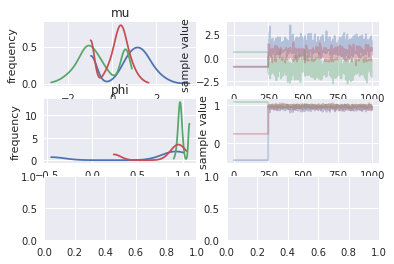

In [30]:
model_fit.plot(['mu', 'phi', 'theta'])

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


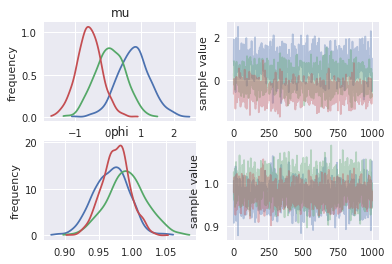

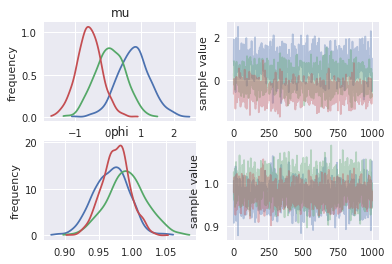

In [20]:
model_fit.plot(['mu', 'phi'])

In [ ]:
%%time

model_name = 'Y~ARMA'
stan_data = {**models[model_name]['stan_data_creator'](pd.DataFrame(rand(100,1)),p=0, q=0), **models[model_name]['parameter_priors']} 

model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs,iter=500)
print(model_fit)

In [43]:
%%time
Y = empirical_time_series.loc[1960:1970]
any_data = Y.isnull().all(axis=0)
Y = Y[any_data[~any_data].index].iloc[:,[0,1,2,3,]]

model_name = 'Y~ARMA'
stan_data = {**models[model_name]['stan_data_creator'](Y,L=1), **models[model_name]['parameter_priors']} 

model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs,iter=500)

RuntimeError: Initialization failed.

In [ ]:
from scipy.stats import gaussian_kde
def predict_with_model(model_name, 
                       time_series,
                       predictors,
                       training_years,
                       horizons,
                       time_series_from_each_time_period,
                       technology_forecast_models_log_pd,
#                        technology_forecast_models_parameters,
                       technology_forecast_models_95CI,
#                        technology_forecast_models_Y_sim,
                       technology_forecast_models_fit, 
                       target_tech_names,
                       model_code=None, 
                       model_parameters=None,
                       parameter_priors=None,
                       print_output=True):
    
    if model_code is None:
        model_code = models[model_name]['code']
    if model_parameters is None:
        model_parameters = models[model_name]['model_parameters']
    if parameter_priors is None:
        parameter_priors = models[model_name]['parameter_priors']
    
    technology_forecast_models_log_pd[model_name] = pd.Panel(items=target_tech_names,
         major_axis=horizons, 
         minor_axis=training_years)
    technology_forecast_models_95CI[model_name] = pd.Panel(items=target_tech_names,
         major_axis=horizons, 
         minor_axis=training_years)
    
#     technology_forecast_models_parameters[model_name] = pd.Panel(items=target_tech_names,
#              major_axis=model_parameters, 
#              minor_axis=training_years)
#     technology_forecast_models_Y_sim[model_name] = {}
    technology_forecast_models_fit[model_name] = {}
    
    for training_year in training_years:
        print(training_year)

        forecast_start_ind = int(training_year-first_year)
        time_series_from_time_period = time_series_from_each_time_period[training_year]
        n_time_series_from_time_period = len(time_series_from_time_period)
        


        if predictors is not None:
            stan_data = stan_data_from_Y(time_series.loc[:training_year, 
                                                        time_series_from_time_period],
                                        forecast_to_observation=time_series.shape[0],
                                        predictors=predictors[time_series_from_time_period])
        else:
            stan_data = stan_data_from_Y(time_series.loc[:training_year, 
                                                    time_series_from_time_period],
                                    forecast_to_observation=time_series.shape[0])
        stan_data = {**stan_data, **parameter_priors} 

        ###
        model_fit = models[model_name]['stan_model'].sampling(data=stan_data, n_jobs=n_jobs)
        Y_sim = model_fit['Y_sim']
#         technology_forecast_models_Y_sim[model_name][training_year] = Y_sim
        
        if print_output:
            print(_print_stanfit(model_fit, model_parameters))
            
        technology_forecast_models_fit[model_name] = model_fit
#         for parameter in model_parameters:
#             technology_forecast_models_parameters[model_name]
#             p = model_fit[parameter].mean(axis=0)

#             if type(p)==numpy.ndarray:
#                 for i in range(len(p)):
#                     technology_forecast_models_parameters[model_name].ix[time_series_from_time_period, 
#                                                         parameter+'_%i'%i,
#                                                         training_year] = p[i]
#             else:        
#                 technology_forecast_models_parameters[model_name].ix[time_series_from_time_period, 
#                                                             parameter,
#                                                             training_year] = p

        for horizon in horizons:
            if horizon=='all':
                forecast_stop_ind = time_series.shape[0]
            else:
                forecast_stop_ind = horizon+forecast_start_ind
            
            times, techs = where(time_series[time_series_from_time_period].notnull())
            techs_to_forecast = techs[(forecast_start_ind<times)*(times<forecast_stop_ind)]
            times_to_forecast = times[(forecast_start_ind<times)*(times<forecast_stop_ind)]
            lpd = list(map(lambda x,y: x.logpdf(y)[0], 
                           map(gaussian_kde, Y_sim[:,times_to_forecast,techs_to_forecast].T), 
                           time_series[time_series_from_time_period].values[times_to_forecast, techs_to_forecast]))

            lpd = array(lpd)
            lpd[lpd==-inf] = log(finfo('d').tiny)
            lpd = pd.groupby(pd.Series(lpd),techs_to_forecast).sum()
            lpd = lpd.reindex(arange(len(time_series_from_time_period)))
            lpd.index = time_series_from_time_period
            technology_forecast_models_log_pd[model_name].ix[time_series_from_time_period,
                                                                 horizon,training_year] = lpd
            CI95 = portion_of_forecast_within_CI(model_fit, 'Y_sim', 
                                                 time_series[time_series_from_time_period].values, 
                                                 forecast_start_ind, 
                                                 forecast_stop_ind)
            technology_forecast_models_95CI[model_name].ix[time_series_from_time_period,
                                                           horizon,training_year] = CI95

In [133]:
print(_print_stanfit(model_fit, pars=['mu', 'sigma']))

4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]       0.5  6.7e-4   0.03   0.44   0.48    0.5   0.52   0.56   2000    1.0
mu[1]      0.49  6.2e-4   0.03   0.44   0.47   0.49   0.51   0.55   2000    1.0
mu[2]      0.49  6.4e-4   0.03   0.43   0.47   0.49   0.51   0.55   2000    1.0
mu[3]      0.46  6.6e-4   0.03    0.4   0.44   0.46   0.48   0.52   2000    1.0
mu[4]      0.47  6.2e-4   0.03   0.42   0.45   0.47   0.49   0.53   2000    1.0
sigma[0]    0.3  5.0e-4   0.02   0.26   0.28   0.29   0.31   0.34   2000    1.0
sigma[1]   0.29  4.7e-4   0.02   0.25   0.27   0.29    0.3   0.33   2000    1.0
sigma[2]   0.29  4.8e-4   0.02   0.25   0.27   0.29    0.3   0.33   2000    1.0
sigma[3]   0.29  4.6e-4   0.02   0.25   0.27   0.29    0.3   0.33   2000    1.0
sigma[4]   0.28  4.6e-4   0.02   0.24   0.27   0.28   0.29   0.32   2000    1.0

Sam